<a href="https://colab.research.google.com/github/PeterTowers/skinLesion/blob/fund_sist_inteligentes/effNet_B2_adam_trainingPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkinLesion - Desafio ISIC 2019 - EfficientNets
Pré-treinadas com o ImageNet.

## Pipeline checklist

1. Configurações da *learning rate*;
2. Épocas de treinamento (inicial e final);
3. Callbacks durante o treinamento;
4. Nome do modelo a ser salvo (número da época final).


## To do:


* Trocar **MICRO** F1-score por *weighted* F1-score (p/ o treinamento final, p/ manter a consistência entre as métricas de comparação):
  * Da forma como a média micro é implementada, seus resultados são iguais (literalmente, os mesmos) aos da acurácia.
*   List item



## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K

from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


### Download dos arquivos do Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip files
!unzip "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/img_shades_cc.zip" -d "."

Streaming output truncated to the last 5000 lines.
  inflating: ./img_shades_cc/ISIC_0065329.jpg  
  inflating: ./img_shades_cc/ISIC_0066774_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0063650.jpg  
  inflating: ./img_shades_cc/ISIC_0033940.jpg  
  inflating: ./img_shades_cc/ISIC_0071678_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0027338.jpg  
  inflating: ./img_shades_cc/ISIC_0056929_aug1.jpg  
  inflating: ./img_shades_cc/ISIC_0061512.jpg  
  inflating: ./img_shades_cc/ISIC_0069094.jpg  
  inflating: ./img_shades_cc/ISIC_0064328_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0033524.jpg  
  inflating: ./img_shades_cc/ISIC_0024390.jpg  
  inflating: ./img_shades_cc/ISIC_0056193_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0028938.jpg  
  inflating: ./img_shades_cc/ISIC_0069119.jpg  
  inflating: ./img_shades_cc/ISIC_0029835.jpg  
  inflating: ./img_shades_cc/ISIC_0069321.jpg  
  inflating: ./img_shades_cc/ISIC_0060482.jpg  
  inflating: ./img_shades_cc/ISIC_0009884.jpg  
  inflating:

Abertura dos dataframes

In [3]:
# Open dataframes containing the images for training, validation and test
train_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_train.csv")

aug_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_train_aug2.csv")

val_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_val.csv")

test_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_test.csv")

## Treinamento da arquitetura EfficientNet-***B2***

### Dependências
#### Métricas

In [ ]:
# Multiclass F1-score MICRO Avg. TODO: remove for final release
micro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='micro',
    name="Micro F1",
)

# Multiclass F1-score MACRO Avg.
macro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='macro',
    name="Macro F1",
)

# Multiclass F1-score weighted (by the number of true instances in each class)
# average
weighted_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='weighted',
    name="Weighted F1",
)

#### Cálculo dos pesos das classes

In [ ]:
# Compute class' weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_df.lesion),
                                     train_df.lesion)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 3.651359143327842, 1: 0.9528697334479793, 2: 1.206518780620577, 3: 13.271706586826348, 4: 0.7002764612954187, 5: 0.2459359742565468, 6: 5.037215909090909, 7: 12.521892655367232}


### Geradores dos tensores (**B2**)

In [4]:
IMG_SIZE = 260
BATCH_SIZE = 32

train_dataGen = ImageDataGenerator(rescale=1./255)

train_generator = train_dataGen.flow_from_dataframe(
    dataframe=aug_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

val_generator = train_dataGen.flow_from_dataframe(
    dataframe=val_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_generator = train_dataGen.flow_from_dataframe(
    dataframe=test_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Found 26450 validated image filenames.
Found 5066 validated image filenames.
Found 2534 validated image filenames.


### Instanciação da arquitetura

In [ ]:
# # Load EfficientNet pre-trained w/ ImageNet
# base_model = EfficientNetB2(include_top=False, weights="imagenet")

# # Rebuild top
# avg = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
# norm = layers.BatchNormalization()(avg)
# dropout = layers.Dropout(0.35, name="top_dropout")(norm)
# output = layers.Dense(8, activation="softmax", name="pred")(dropout)

# model = tf.keras.Model(base_model.input, output, name="EfficientNetB2_aug2")

# # Freeze the pretrained weights
# for layer in base_model.layers:
#     layer.trainable = False

31801344/31790344 [==============================] - 0s 0us/step


### Otimizador **Adam**

#### Treinamento das camadas superiores

In [ ]:
# # Load previous best weights
# model.load_weights(
#      '/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_15top10').expect_partial()

# # Learning rate scheduler
# lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=827*10,
#     decay_rate=0.1,
#     staircase=True)

# # Optimizer setup
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# # Metrics
# metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
#            micro_f1, macro_f1, weighted_f1]

# # Compile model
# model.compile(optimizer=optimizer, loss="categorical_crossentropy",
#               metrics=metrics)

In [ ]:
# Train with callback (early stopping)
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=20, restore_best_weights=True)

# # Model checkpoint: monitoring val_loss, saving only the best results
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_top{epoch:02d}",
#     monitor='val_loss', verbose=1, save_best_only=True,
#     save_weights_only=False, mode='min')

In [ ]:
# # Top layers training: Epochs - min:8; max:80
# history = model.fit(train_generator, validation_data=val_generator, epochs=20,
#                     class_weight=class_weights,
#                     callbacks=[checkpoint])

Epoch 1/20
827/827 [==============================] - 533s 595ms/step - loss: 5.1099 - Categorical Accuracy: 0.1653 - Micro F1: 0.1653 - Macro F1: 0.0750 - Weighted F1: 0.1201 - val_loss: 2.1218 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00001: val_loss improved from inf to 2.12175, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_top01
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_top01/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
827/827 [==============================] - 463s 560ms/step - loss: 4.9115 - Categorical Accuracy: 0.1709 - Micro F1: 0.1709 - Macro F1: 0.0677 - Weighted F1: 0.1056 - val_loss: 2.1645 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00002: val_loss did not improve from 2.12175
Epoch 3/20
827/827 [==============================] - 437s 528ms/step - loss: 4.8291 - Categorical Accuracy: 0.1747 - Micro F1: 0.1747 - Macro F1: 0.0675 - Weighted F1: 0.1045 - val_loss: 2.2039 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00003: val_loss did not improve from 2.12175
Epoch 4/20
827/827 [==============================] - 430s 520ms/step - loss: 4.7922 - Categorical Accuracy: 0.1710 - Micro F1: 0.1710 - Macro F1: 0.0650 - Weighted F1: 0.0993 - val_loss: 2.0574 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20
827/827 [==============================] - 437s 529ms/step - loss: 4.7446 - Categorical Accuracy: 0.1712 - Micro F1: 0.1712 - Macro F1: 0.0631 - Weighted F1: 0.0987 - val_loss: 2.1473 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00005: val_loss did not improve from 2.05744
Epoch 6/20
827/827 [==============================] - 440s 532ms/step - loss: 4.7397 - Categorical Accuracy: 0.1735 - Micro F1: 0.1735 - Macro F1: 0.0635 - Weighted F1: 0.0978 - val_loss: 2.1145 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00006: val_loss did not improve from 2.05744
Epoch 7/20
827/827 [==============================] - 439s 531ms/step - loss: 4.7254 - Categorical Accuracy: 0.1769 - Micro F1: 0.1769 - Macro F1: 0.0657 - Weighted F1: 0.1005 - val_loss: 2.1487 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/20
827/827 [==============================] - 444s 537ms/step - loss: 4.6970 - Categorical Accuracy: 0.1778 - Micro F1: 0.1778 - Macro F1: 0.0623 - Weighted F1: 0.0973 - val_loss: 2.1280 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00010: val_loss did not improve from 2.02996
Epoch 11/20
827/827 [==============================] - 444s 537ms/step - loss: 4.5293 - Categorical Accuracy: 0.1997 - Micro F1: 0.1997 - Macro F1: 0.0590 - Weighted F1: 0.0936 - val_loss: 2.1110 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00011: val_loss did not improve from 2.02996
Epoch 12/20
827/827 [==============================] - 444s 536ms/step - loss: 4.5203 - Categorical Accuracy: 0.1989 - Micro F1: 0.1989 - Macro F1: 0.0589 - Weighted F1: 0.0934 - val_loss: 2.1069 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighte

In [ ]:
# # Make new dataframe containing model's top training history
# top_history = pd.DataFrame.from_dict(history.history)

# # Save metrics' history as CSV
# top_history.to_csv(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamTopHistory.csv",
#     index=False)

In [ ]:
# # Save whole model with the top trained
# model.save(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamTop20")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamTop20/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


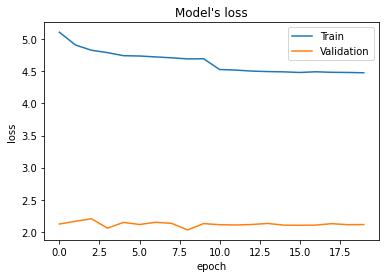

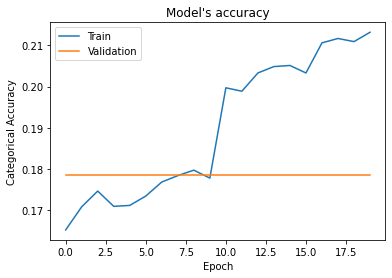

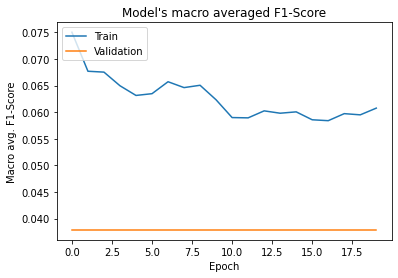

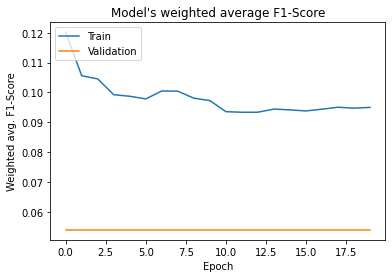

In [ ]:
# # Summarize history for loss
# plt.plot(top_history['loss'])
# plt.plot(top_history['val_loss'])
# plt.title('Model\'s loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()
# print()

# # Summarize history for accuracy
# plt.plot(top_history['Categorical Accuracy'])
# plt.plot(top_history['val_Categorical Accuracy'])
# plt.title('Model\'s accuracy')
# plt.ylabel('Categorical Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for MACRO avg. F1-Score
# plt.plot(top_history['Macro F1'])
# plt.plot(top_history['val_Macro F1'])
# plt.title('Model\'s macro averaged F1-Score')
# plt.ylabel('Macro avg. F1-Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for weighted avg. F1
# plt.plot(top_history['Weighted F1'])
# plt.plot(top_history['val_Weighted F1'])
# plt.title('Model\'s weighted average F1-Score')
# plt.ylabel('Weighted avg. F1-Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

#### Treinamento de todas as camadas

In [ ]:
# Load FULL model
model = keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull_20")

In [ ]:
# # Unfreeze all layer's pretrained weights
# for layer in model.layers:
#     layer.trainable = True

# # Learning rate scheduler (starts at 10^(-3) and drops by a factor of 10^(-1)
# # every 10 epochs)
# lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=827*10,
#     decay_rate=0.1,
#     staircase=True)

# # Optimizer setup
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# # Metrics
# metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
#            micro_f1, macro_f1, weighted_f1]

# # Compile model
# model.compile(optimizer=optimizer, loss="categorical_crossentropy",
#               metrics=metrics)

In [ ]:
# Learning rate scheduler (starts at 10^(-3) and drops by a factor of 10^(-1)
# every 10 epochs)
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=827*15,
    decay_rate=0.1,
    staircase=True)

# Optimizer setup
model.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# # Change learning rate after a few epochs of training
# LEARNING_RATE = 1e-3
# K.set_value(model.optimizer.learning_rate, LEARNING_RATE)

# # Change BETA_1 hyperparameter
# BETA_1 = 0.9
# K.set_value(model.optimizer.beta_1, BETA_1)

# # Change BETA_2 hyperparameter
# BETA_2 = 0.999
# K.set_value(model.optimizer.beta_2, BETA_2)

# Verify changes
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': {'class_name': 'ExponentialDecay',
  'config': {'decay_rate': 0.1,
   'decay_steps': 12405,
   'initial_learning_rate': 0.0001,
   'name': None,
   'staircase': True}},
 'name': 'Adam'}

In [ ]:
!nvidia-smi

Wed Nov  3 11:30:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    59W / 149W |    247MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Train with callback (early stopping)
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=20, restore_best_weights=True)

# Save whole model's state based on validation loss (best only)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull{epoch:02d}",
    monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

In [ ]:
# ALL layers training (CHECK 'epochs' and 'initial_epoch' before start)
history = model.fit(train_generator, validation_data=val_generator, epochs=40,
                    class_weight=class_weights,
                    callbacks=[checkpoint],
                    initial_epoch=20)

Epoch 21/40
827/827 [==============================] - 1018s 1s/step - loss: 0.5497 - Categorical Accuracy: 0.8251 - Micro F1: 0.8251 - Macro F1: 0.7442 - Weighted F1: 0.8150 - val_loss: 2.3988 - val_Categorical Accuracy: 0.4064 - val_Micro F1: 0.4064 - val_Macro F1: 0.1906 - val_Weighted F1: 0.4317

Epoch 00021: val_loss improved from inf to 2.39876, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull21
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull21/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull21/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/40
827/827 [==============================] - 968s 1s/step - loss: 0.4925 - Categorical Accuracy: 0.8392 - Micro F1: 0.8392 - Macro F1: 0.7565 - Weighted F1: 0.8298 - val_loss: 2.3820 - val_Categorical Accuracy: 0.3893 - val_Micro F1: 0.3893 - val_Macro F1: 0.2556 - val_Weighted F1: 0.3902

Epoch 00022: val_loss improved from 2.39876 to 2.38203, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull22
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull22/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull22/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/40
827/827 [==============================] - 961s 1s/step - loss: 0.4352 - Categorical Accuracy: 0.8559 - Micro F1: 0.8559 - Macro F1: 0.7729 - Weighted F1: 0.8471 - val_loss: 3.5160 - val_Categorical Accuracy: 0.2639 - val_Micro F1: 0.2639 - val_Macro F1: 0.0812 - val_Weighted F1: 0.2809

Epoch 00023: val_loss did not improve from 2.38203
Epoch 24/40
827/827 [==============================] - 959s 1s/step - loss: 0.4035 - Categorical Accuracy: 0.8651 - Micro F1: 0.8651 - Macro F1: 0.7849 - Weighted F1: 0.8568 - val_loss: 3.2527 - val_Categorical Accuracy: 0.2738 - val_Micro F1: 0.2738 - val_Macro F1: 0.1384 - val_Weighted F1: 0.3111

Epoch 00024: val_loss did not improve from 2.38203
Epoch 25/40
827/827 [==============================] - 961s 1s/step - loss: 0.3663 - Categorical Accuracy: 0.8769 - Micro F1: 0.8769 - Macro F1: 0.7979 - Weighted F1: 0.8693 - val_loss: 3.1958 - val_Categorical Accuracy: 0.4242 - val_Micro F1: 0.4242 - val_Macro F1: 0.1139 - val_Weighted F1: 0.3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull27/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/40
827/827 [==============================] - 969s 1s/step - loss: 0.2932 - Categorical Accuracy: 0.8997 - Micro F1: 0.8997 - Macro F1: 0.8084 - Weighted F1: 0.8927 - val_loss: 4.0695 - val_Categorical Accuracy: 0.2136 - val_Micro F1: 0.2136 - val_Macro F1: 0.0786 - val_Weighted F1: 0.2322

Epoch 00028: val_loss did not improve from 2.02036
Epoch 29/40
827/827 [==============================] - 970s 1s/step - loss: 0.2641 - Categorical Accuracy: 0.9085 - Micro F1: 0.9085 - Macro F1: 0.8249 - Weighted F1: 0.9022 - val_loss: 3.8632 - val_Categorical Accuracy: 0.1309 - val_Micro F1: 0.1309 - val_Macro F1: 0.0931 - val_Weighted F1: 0.1607

Epoch 00029: val_loss did not improve from 2.02036
Epoch 30/40
827/827 [==============================] - 967s 1s/step - loss: 0.2431 - Categorical Accuracy: 0.9164 - Micro F1: 0.9164 - Macro F1: 0.8320 - Weighted F1: 0.9106 - val_loss: 3.1901 - val_Categorical Accuracy: 0.4214 - val_Micro F1: 0.4214 - val_Macro F1: 0.2686 - val_Weighted F1: 0.4

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull31/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/40
827/827 [==============================] - 967s 1s/step - loss: 0.2019 - Categorical Accuracy: 0.9293 - Micro F1: 0.9293 - Macro F1: 0.8446 - Weighted F1: 0.9242 - val_loss: 2.6128 - val_Categorical Accuracy: 0.5588 - val_Micro F1: 0.5588 - val_Macro F1: 0.3451 - val_Weighted F1: 0.5395

Epoch 00032: val_loss did not improve from 1.85024
Epoch 33/40
827/827 [==============================] - 966s 1s/step - loss: 0.1902 - Categorical Accuracy: 0.9328 - Micro F1: 0.9328 - Macro F1: 0.8499 - Weighted F1: 0.9278 - val_loss: 1.4426 - val_Categorical Accuracy: 0.7169 - val_Micro F1: 0.7169 - val_Macro F1: 0.5289 - val_Weighted F1: 0.6954

Epoch 00033: val_loss improved from 1.85024 to 1.44264, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull33
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull33/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull33/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/40
252/827 [========>.....................] - ETA: 10:22 - loss: 0.1597 - Categorical Accuracy: 0.9421 - Micro F1: 0.9421 - Macro F1: 0.8615 - Weighted F1: 0.9376

In [ ]:
# Open csv with top layers' training metrics
history_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug_2adamHistory.csv")

# Make new dataframe with current values
new_entries = pd.DataFrame.from_dict(history.history)

# # Append new values to old dataframe
history_df = history_df.append(new_entries, ignore_index=True)

# Save metrics' history as CSV
history_df.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug_2adamHistory.csv",
    index=False)

In [ ]:
# Save whole model (CHECK CURRENT EPOCH BEFORE SAVING)
model.save(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull_40")

##### Resultados

Valores de perda do conjunto de treino e de validação

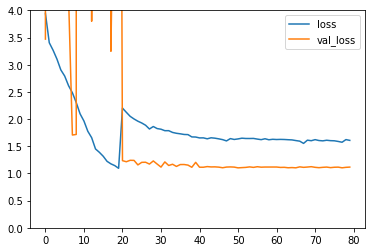

In [11]:
# history_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug_2adamHistory.csv")
history_df.plot(y=['loss', 'val_loss'], ylim=(0, 4))

Valores de perda do conjunto de validação

In [ ]:
history_df.plot(y='val_loss', ylim=(0, 3.5))

Todas as métricas

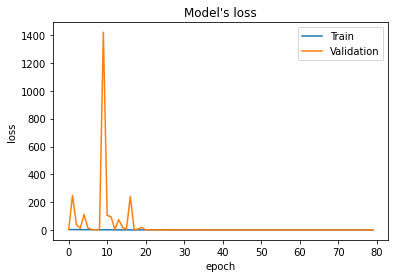

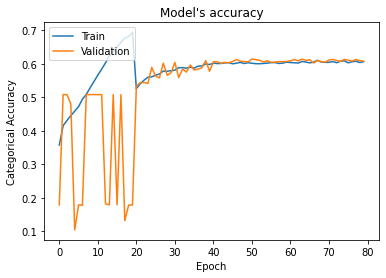

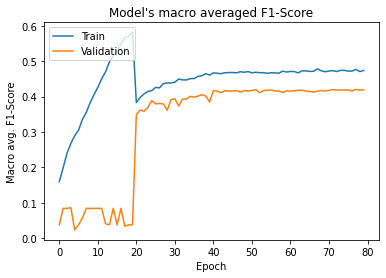

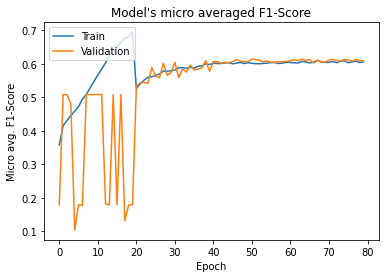

In [3]:
history_df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_history.csv")

# Summarize history for loss
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print()

# Summarize history for accuracy
plt.plot(history_df['Categorical Accuracy'])
plt.plot(history_df['val_Categorical Accuracy'])
plt.title('Model\'s accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MACRO avg. F1-Score
plt.plot(history_df['Macro F1'])
plt.plot(history_df['val_Macro F1'])
plt.title('Model\'s macro averaged F1-Score')
plt.ylabel('Macro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MICRO avg. F1
plt.plot(history_df['Micro F1'])
plt.plot(history_df['val_Micro F1'])
plt.title('Model\'s micro averaged F1-Score')
plt.ylabel('Micro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

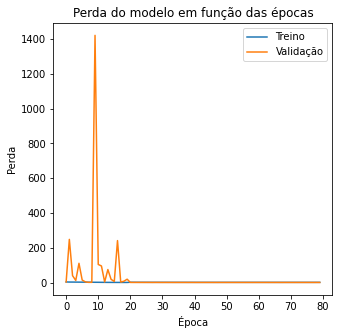

In [20]:
# Summarize history for loss
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
ax.plot(history_df['loss'])
ax.plot(history_df['val_loss'])
# plt.ylim((0,4))
plt.title("Perda do modelo em função das épocas")
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.savefig("adam_loss5.png")

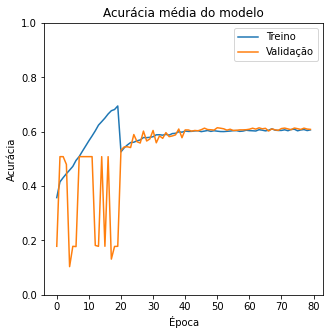

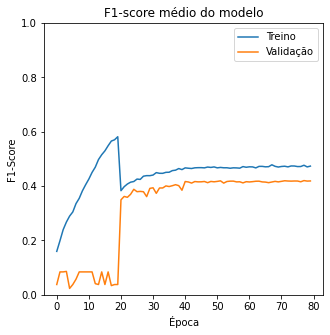

In [18]:
# Summarize history for accuracy
fig_acc = plt.figure(figsize=(5, 5))
ax_acc = plt.subplot()
ax_acc.plot(history_df['Categorical Accuracy'])
ax_acc.plot(history_df['val_Categorical Accuracy'])
plt.ylim((0, 1))
plt.title("Acurácia média do modelo")
plt.ylabel("Acurácia")
plt.xlabel("Época")
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.savefig("adam_acc5.png")

# Summarize history for MACRO avg. F1-Score
fig_f1 = plt.figure(figsize=(5, 5))
ax_f1 = plt.subplot()
ax_f1.plot(history_df['Macro F1'])
ax_f1.plot(history_df['val_Macro F1'])
plt.ylim((0, 1))
plt.title("F1-score médio do modelo")
plt.ylabel('F1-Score')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.savefig("adam_f1_5.png")

## Testes

In [6]:
model = keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_full78")

### Conjunto de validação

In [7]:
# Predicts labels
val_predictions = model.predict(val_generator, verbose=1)

print(classification_report(val_generator.labels.argmax(1),
                            val_predictions.argmax(1), zero_division=0))

159/159 [==============================] - 109s 484ms/step
              precision    recall  f1-score   support

           0       0.18      0.33      0.24       904
           1       0.50      0.41      0.45      2575
           2       0.13      0.08      0.10       665
           3       0.04      0.11      0.06       173
           4       0.11      0.01      0.01       525
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        51
           7       0.02      0.05      0.03       125

    accuracy                           0.29      5066
   macro avg       0.12      0.12      0.11      5066
weighted avg       0.32      0.29      0.29      5066



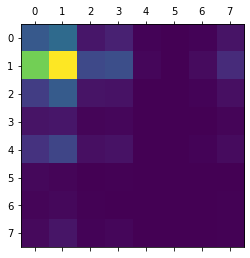

In [12]:
# Confusion matrix
confusion = tf.math.confusion_matrix(val_generator.labels.argmax(1),
                                     val_predictions.argmax(1))

plt.matshow(confusion)

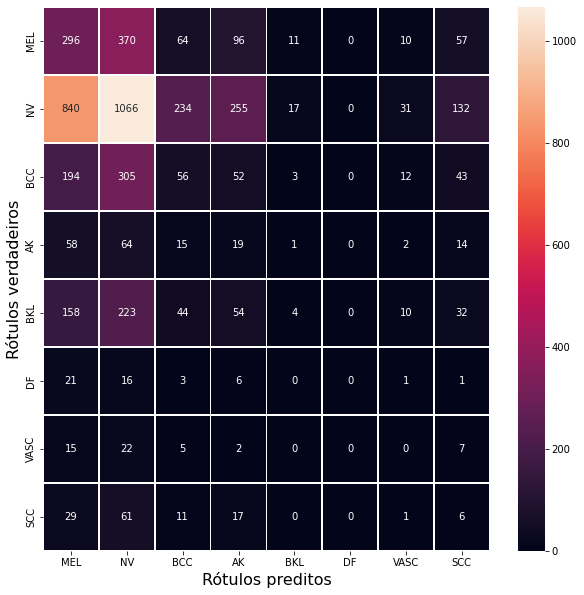

In [56]:
import seaborn as sns

# Confusion matrix (for printing)
confusion_matrix = confusion.numpy()

con_matrix = plt.figure(figsize=(10, 10))
ax_matrix = plt.subplot()

matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5)

classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

plt.xlabel("Rótulos preditos", fontsize=16)
plt.ylabel('Rótulos verdadeiros', fontsize=16)

ax_matrix.set_yticklabels(classes)
ax_matrix.set_xticklabels(classes)

plt.savefig("val_confusion10.png")

In [57]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("Acurácia:       {}".format(ACC))

True positive:  [ 296 1066   56   19    4    0    0    6]
True negative:  [2847 1430 4025 4411 4509 5018 4948 4655]
False positive: [1315 1061  376  482   32    0   67  286]
False negative: [ 608 1509  609  154  521   48   51  119]

Sensibilidade:  [0.32743363 0.41398058 0.08421053 0.10982659 0.00761905 0.
 0.         0.048     ]
Especificidade: [0.68404613 0.57406664 0.91456487 0.90149193 0.99295309 1.
 0.98664008 0.94211698]
Precisão:       [0.18373681 0.50117536 0.12962963 0.03792415 0.11111111 0.
 0.         0.02054795]
Acurácia:       [0.62041058 0.49269641 0.80556652 0.87445717 0.8908409  0.99052507
 0.97670746 0.92005527]


### Conjunto de teste

In [58]:
# Predicts labels
test_predictions = model.predict(test_generator, verbose=1)

print(classification_report(test_generator.labels.argmax(1),
                            test_predictions.argmax(1),
                            zero_division=0))

80/80 [==============================] - 39s 490ms/step
              precision    recall  f1-score   support

           0       0.18      0.30      0.22       453
           1       0.51      0.43      0.47      1288
           2       0.11      0.08      0.09       332
           3       0.03      0.08      0.04        87
           4       0.06      0.00      0.01       262
           5       0.00      0.00      0.00        24
           6       0.07      0.12      0.09        25
           7       0.02      0.03      0.02        63

    accuracy                           0.29      2534
   macro avg       0.12      0.13      0.12      2534
weighted avg       0.31      0.29      0.29      2534



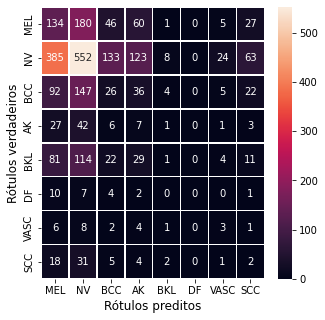

In [60]:
import seaborn as sns

confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
                                     test_predictions.argmax(1))

# Confusion matrix (for printing)
confusion_matrix = confusion.numpy()

con_matrix = plt.figure(figsize=(5, 5))
ax_matrix = plt.subplot()

matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

plt.xlabel("Rótulos preditos", fontsize=12)
plt.ylabel('Rótulos verdadeiros', fontsize=12)

ax_matrix.set_yticklabels(classes)
ax_matrix.set_xticklabels(classes)

plt.savefig("test_confusion5.png")

In [61]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("Acurácia:       {}".format(ACC))

True positive:  [134 552  26   7   1   0   3   2]
True negative:  [1462  717 1984 2189 2255 2510 2469 2343]
False positive: [619 529 218 258  17   0  40 128]
False negative: [319 736 306  80 261  24  22  61]

Sensibilidade:  [0.29580574 0.42857143 0.07831325 0.08045977 0.00381679 0.
 0.12       0.03174603]
Especificidade: [0.70254685 0.57544141 0.90099909 0.89456477 0.99251761 1.
 0.98405739 0.94819911]
Precisão:       [0.17795485 0.5106383  0.10655738 0.02641509 0.05555556 0.
 0.06976744 0.01538462]
Acurácia:       [0.62983425 0.50078927 0.79321231 0.86661405 0.89029203 0.99052881
 0.97553275 0.92541436]


In [62]:
!zip confusion.zip *.png

  adding: test_confusion10.png (deflated 12%)
  adding: test_confusion5.png (deflated 5%)
  adding: val_confusion10.png (deflated 11%)
  adding: val_confusion5.png (deflated 5%)


### Modelo p/ copiar e colar

*   Batch size: 32;
*   Topo treinado por XX épocas;
*   Número de épocas de treinamento: YY;
*   *Learning rate*: ZZ;

In [ ]:
# # Predicts labels
# test_predictions = model.predict(test_generator, verbose=1)

# print(classification_report(test_generator.labels.argmax(1),
#                             test_predictions.argmax(1),
#                             zero_division=0))

In [ ]:
# # Confusion matrix
# confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
#                                      test_predictions.argmax(1))

# plt.matshow(confusion)

In [ ]:
# import seaborn as sns

# confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
#                                      test_predictions.argmax(1))

# # Confusion matrix (for printing)
# confusion_matrix = confusion.numpy()

# con_matrix = plt.figure(figsize=(5, 5))
# ax_matrix = plt.subplot()

# matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.25)

# classes = ["MEL", "NV", "BCC",  "AK", "BKL", "DF", "VASC", "SCC"]

# plt.xlabel("Rótulos preditos", fontsize=12)
# plt.ylabel('Rótulos verdadeiros', fontsize=12)

# ax_matrix.set_yticklabels(classes)
# ax_matrix.set_xticklabels(classes)

# plt.savefig("test_confusion5.png")

In [ ]:
# # # Cast to numpy array
# # confusion_matrix = confusion.numpy()

# FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
# FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
# TP = np.diag(confusion_matrix)
# TN = confusion_matrix.sum() - (FP + FN + TP)

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = np.divide(TP, (TP+FN),
#                 out=np.zeros(TP.shape, dtype=float),
#                 where=((TP+FN) != 0))

# # Specificity or true negative rate
# TNR = np.divide(TN, (TN+FP),
#                 out=np.zeros(TN.shape, dtype=float),
#                 where=((TN+FP) != 0))

# # Precision or positive predictive value
# PPV = np.divide(TP, (TP+FP),
#                 out=np.zeros(TP.shape, dtype=float),
#                 where=((TP+FP) != 0))

# # Negative predictive value
# NPV = np.divide(TN, (TN+FN),
#                 out=np.zeros(TN.shape, dtype=float),
#                 where=((TN+FN) != 0))

# # Fall out or false positive rate
# FPR = np.divide(FP, (FP+TN),
#                 out=np.zeros(FP.shape, dtype=float),
#                 where=((FP+TN) != 0))

# # False negative rate
# FNR = np.divide(FN, (TP+FN),
#                 out=np.zeros(FN.shape, dtype=float),
#                 where=((TP+FN) != 0))

# # False discovery rate
# FDR = np.divide(FP, (TP+FP),
#                 out=np.zeros(FP.shape, dtype=float),
#                 where=((TP+FP) != 0))

# # Overall accuracy
# ACC = np.divide((TP+TN), (TP+FP+FN+TN),
#                 out=np.zeros((TP+TN).shape, dtype=float),
#                 where=((TP+FP+FN+TN) != 0))

# # c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
# print("True positive:  {}".format(TP))
# print("True negative:  {}".format(TN))
# print("False positive: {}".format(FP))
# print("False negative: {}".format(FN), end="\n\n")

# print("Sensibilidade:  {}".format(TPR))
# print("Especificidade: {}".format(TNR))
# print("Precisão:       {}".format(PPV))
# print("Acurácia:       {}".format(ACC))